# LSTM implementation
<hr>
This notebook implements a LSTM model to predict a vector of outputs (Y) given an history of inputs (X).
Using the generator by Chollet where (`lookback`,`num_features`) -> (`targets`)
<br><br>
<b id="tocheading">Table of Contents</b>
<hr>
<div id="toc"></div>


In [57]:
%%javascript
/* Generate Table of Contents */
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## 1. Initialisation

In [58]:
# reset variables and set global paths
%reset -f 
import os, sys

ROOT_PATH = os.path.abspath(".").split("src")[0]
if (os.path.join(ROOT_PATH, 'src') not in sys.path):
    sys.path.append(os.path.join(ROOT_PATH, 'src'))

In [59]:
# import essential libraries
import numpy as np
import pandas as pd
import datetime

# keras used for deep learning
import keras; print("keras.__version__ =", keras.__version__ )
from keras import layers, regularizers, Input, Model
from tensorflow.python.keras.initializers import RandomUniform
from keras.optimizers import RMSprop, Adam, Nadam
from keras.models import Sequential
from keras import backend as K

# tensorflow
import tensorflow as tf; print("tf.__version__ =", tf.__version__)
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# plotting
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

keras.__version__ = 2.2.4
tf.__version__ = 1.12.0


In [60]:
# configure matplotlib params and plotting
## use seaborn as this gives nicer plots than the standard 
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(12,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=14, handlelength=2)

# set seeds for reproducibility
SEED=100
np.random.seed(SEED)
tf.set_random_seed(SEED)

## 2. Data loading
<hr> 
Load data from pre-stored files

In [61]:
DATA_PATH = ROOT_PATH + "data/project-thesis/"
num_obs = 6000  # 6000, 20000 or 50000; number of observations to use

df2np = np.load(DATA_PATH + "dummy_data/dummy_complete_{}.npy".format(num_obs))
df2np_train = np.load(DATA_PATH + "dummy_data/dummy_train_{}.npy".format(num_obs))
df2np_valid = np.load(DATA_PATH + "dummy_data/dummy_valid_{}.npy".format(num_obs))
df2np_test = np.load(DATA_PATH + "dummy_data/dummy_test_{}.npy".format(num_obs))

train_size = df2np_train.shape[0]
valid_size = df2np_valid.shape[0]
test_size = df2np_test.shape[0]

print("Training set size:   \t", train_size)
print("Validation set size: \t", valid_size)
print("Testing set size:    \t", test_size)

# read metadata
feature_tags = list(np.load(DATA_PATH + "metadata/feature_tags.npy"))
target_tags = list(np.load(DATA_PATH + "metadata/target_tags.npy"))
headers = feature_tags + target_tags

means = np.load(DATA_PATH + "metadata/means.npy")
stds = np.load(DATA_PATH + "metadata/stds.npy")

Training set size:   	 3600
Validation set size: 	 1200
Testing set size:    	 1200


In [62]:
# only use one of the outputs
delay = 0 # do not lag the data at all
lookback=100 # use the 100 previous observations in each batch
batch_size=128 # use 128 observations in each batch

inputs_idxs = np.array(range(len(feature_tags)))
#outputs_idxs = np.array(range(len(feature_tags), len(headers)))
outputs_idxs = np.array([8])

x_train = df2np_train[:,inputs_idxs]
y_train = df2np_train[:,outputs_idxs]

x_valid = df2np_valid[:,inputs_idxs]
y_valid = df2np_valid[:,outputs_idxs]

x_test = df2np_test[:-delay,inputs_idxs]
y_test = df2np_test[delay:,outputs_idxs]

print(x_train.shape, y_train.shape)
assert x_train.shape[0] == y_train.shape[0] and x_train.shape[1]==len(feature_tags) and y_train.shape[1]==len(outputs_idxs)

(3600, 6) (3600, 1)


### Plots
Try and plot the data to get a feel for it

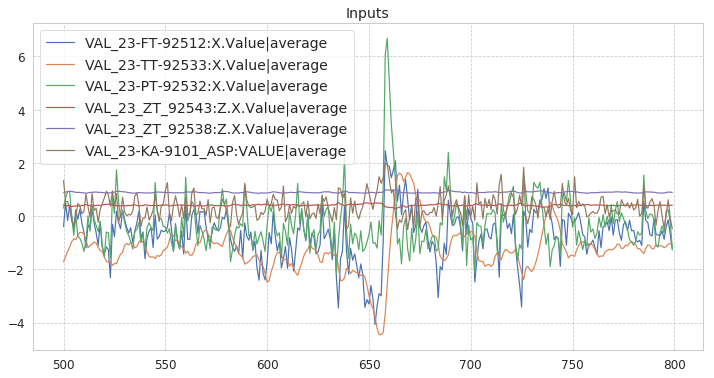

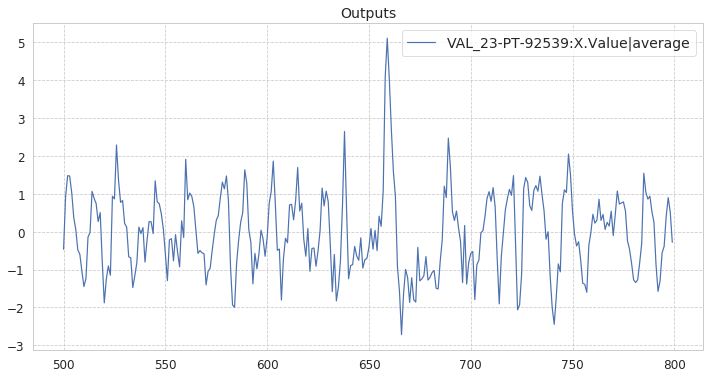

In [63]:
plot_from = 500
number_of_steps = 300
plot_to=plot_from+number_of_steps

plt.figure()
for signal in range(len(feature_tags)):
    plt.plot(range(plot_from, plot_to), df2np_train[plot_from:plot_to,signal], label=feature_tags[signal])
plt.title("Inputs")
plt.legend(frameon=True)
plt.show()

plt.figure()
for signal in outputs_idxs:
    plt.plot(range(plot_from, plot_to), df2np_train[plot_from:plot_to,signal], 
             label=target_tags[signal-len(feature_tags)])

plt.title("Outputs")
plt.legend(frameon=True)
plt.show()

## 3. Defining a Generator
<hr>
Define a generator to generate batches of data such that the models don't have to read everything at once. 

### Definition

In [64]:
def generator(x_data, y_data, lookback=100, delay=0, min_index=0, max_index=None,
              shuffle=False, batch_size=128, step=1):
    """
    Generates batches of data. Returns tensors of shape (batch_size, lookback, features).
    Samples have shape (batch_size, lookback, predictors)
    Targets have shape (batch_size, features)
    -> In other words, for a single batch: (lookback,predictors) => mapped to => (features,)
    -> A history of inputs are mapped to a single feature
    """
    
    if max_index is None:
        max_index = len(x_data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        # 3D tensors have shape (batch_size, timesteps (lookback), features)
        num_output_timesteps = delay if delay > 0 else 1
        
        samples = np.zeros((len(rows),
                           lookback // step,
                           x_data.shape[-1]))
        targets = np.zeros((len(rows),
                            y_data.shape[-1]))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            indices_targets = rows[j] + delay 
            
            samples[j] = x_data[indices]
            targets[j] = y_data[indices_targets]
            #targets[j] = np.reshape(y_data[indices_targets], (num_output_timesteps, y_data.shape[-1]))
        yield samples, targets

In [65]:
def choose_generator_steps(data, lookback, delay, batch_size):
    """
    Function to choose the maximum number of generator steps such that the generator
    doesn't overflow the number of observations
    """
    return ((len(data) - lookback - delay - (batch_size-1)) // batch_size) + 1


def get_true_targets(true_data, batch_size, lookback, increment=0, batch=None, delay=0):
    """
    Returns the true targets for the generator
    """
    if batch is not None: 
        # Get target for specific batch
        start_idx = batch + lookback + increment*batch_size + delay
        end_idx = start_idx + 1 + delay
        
    else: 
        # Get targets for all batches
        start_idx = lookback + increment*batch_size + delay
        end_idx = start_idx + batch_size + delay
    
    idxs = range(start_idx, end_idx)
    return true_data[idxs]

### Verifying and testing the generator
Verify that the generator works as expected

(128, 100, 6) (128, 1)


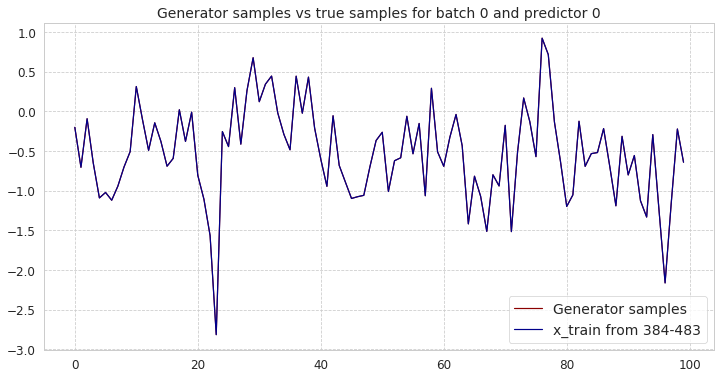

Targets equal? 1.1505 == 1.1505: True


In [66]:
batch_size, lookback, delay = 128, 100, 0
gen = generator(x_train, y_train, batch_size=batch_size, lookback=lookback, delay=delay)
samples, targets = next(gen)

batch = 0
increment = 3
for inc in range(increment):
    samples, targets = next(gen)

print(samples.shape, targets.shape)
predictor = 0
start_samples = batch + increment*batch_size
end_samples = batch + lookback + increment*batch_size
idxs = range(start_samples,end_samples)

gen_samples = samples[batch,:,predictor]
true_samples = x_train[idxs,predictor]

# plot should show that gen_samples == true_samples
plt.figure()
plt.plot(gen_samples, c="darkred", 
         label="Generator samples")
plt.plot(true_samples, c="darkblue",
         label="x_train from {0}-{1}".format(idxs[0],idxs[-1]))
plt.title("Generator samples vs true samples for batch {0} and predictor {1}".format(batch,predictor))
plt.legend(frameon=True)
plt.show()

feature = 0
gen_targets = targets[batch,feature]
true_targets = get_true_targets(true_data=y_train, batch_size=batch_size, delay=delay,
                                 lookback=lookback, increment=increment, batch=batch)[0,feature]
print("Targets equal? {0} == {1}: {2}".format(round(gen_targets,4), round(true_targets,4), np.all(gen_targets==true_targets)))

In [67]:
def test_generator(generator, x_data, y_data, batch_size=128, lookback=100, delay=0):
    gen = generator(x_data, y_data, lookback=lookback, delay=delay)
    gen_steps = choose_generator_steps(x_data,lookback,delay,batch_size)
    
    for increment in range(gen_steps):
        samples, targets = next(gen)
        
        for batch in range(batch_size): 
            
            # *-----------------------------*
            # testing the samples/predictors
            # *-----------------------------*
            start_samples = batch + increment*batch_size
            end_samples = batch + lookback + increment*batch_size
            idxs=range(start_samples,end_samples)
            
            # samples[0,:,0] should equal data[start:end,0]
            for predictor in range(x_data.shape[-1]):
                assert np.all(samples[batch,:,predictor] == x_data[idxs,predictor])
            
            
            # *---------------------------*
            # testing the targets/features
            # *---------------------------*

            # targets[0,0] should equal data[start:end,0]
            for feature in range(y_data.shape[-1]):
                gen_targets = targets[batch,feature]
                true_targets = get_true_targets(true_data=y_data, batch_size=batch_size, delay=delay,
                                                lookback=lookback, increment=increment, batch=batch)[0,feature]
                assert np.all(gen_targets == true_targets)

In [68]:
test_generator(generator, x_train, y_train, batch_size=128, lookback=100, delay=0)

## 4. Model implementation
---

In [69]:
def plot_history(history, savepath=None):
    """
    Plots the training and validation loss history of the model in the training phase. 
    """
    epochs = history.epoch

    train_mae = history.history['loss']
    val_mae = history.history['val_loss']

    plt.figure()
    plt.plot(epochs, train_mae, marker='o', markersize='3.0', label=r'Training loss', color="darkred")
    plt.plot(epochs, val_mae, marker='o', markersize='3.0', label=r'Validation loss', color="darkblue")  
    plt.xlabel(r'Epoch')
    plt.ylabel(r'MAE')
    plt.legend(frameon=True)
    if savepath is not None: 
        plt.savefig(savepath)
    plt.show()

### Defining the architecture

In [70]:
def build_model(input_layer, num_output_signals):  
    layer_1 = layers.GRU(128,
                         dropout = 0.2,
                         recurrent_dropout = 0.2,
                         kernel_initializer = 'glorot_normal')(input_layer)
    
    init = RandomUniform(minval=-0.05, maxval=0.05)
    output_layer = layers.Dense(num_output_signals, kernel_initializer=init)(layer_1)
    
    model = Model(input_layer, output_layer) 
    return model

### Training the model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 6)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               51840     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 51,969
Trainable params: 51,969
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
26/26 [==============================] - 4s 157ms/step - loss: 0.7441 - val_loss: 0.6943
Epoch 2/10
26/26 [==============================] - 4s 144ms/step - loss: 0.5759 - val_loss: 0.6049
Epoch 3/10
26/26 [==============================] - 4s 143ms/step - loss: 0.5426 - val_loss: 0.5679
Epoch 4/10
26/26 [==============================] - 4s 145ms/step - loss: 0.5327 - val_loss: 0.5369
Ep

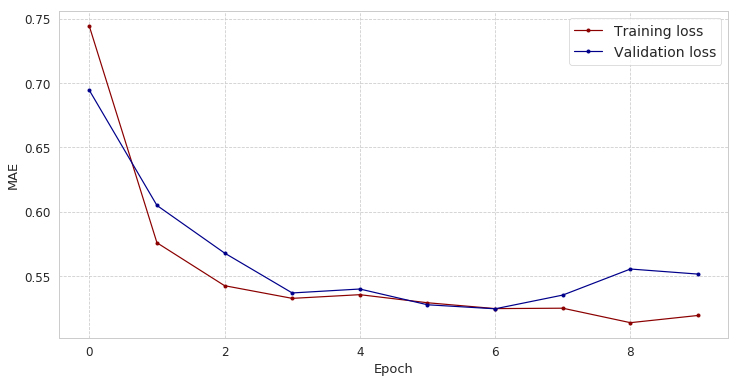

In [71]:
# Defining variables 
batch_size=128
lookback=200
delay=0
epochs=10

# Defining generators and generator steps
train_gen = generator(x_train, y_train, lookback=lookback, batch_size=batch_size, delay=delay)
valid_gen = generator(x_valid, y_valid, lookback=lookback, batch_size=batch_size, delay=delay)
train_steps = choose_generator_steps(x_train, lookback=lookback, batch_size=batch_size, delay=delay)
valid_steps = choose_generator_steps(x_valid, lookback=lookback, batch_size=batch_size, delay=delay)

# Train the model
K.clear_session()
input_layer = Input(shape=(None,x_train.shape[-1]))
model = build_model(input_layer, y_train.shape[-1])
model.compile(loss='MAE', optimizer='ADAM')
model.summary()

history = model.fit_generator(generator=train_gen,
                              epochs=epochs,
                              steps_per_epoch=train_steps,
                              validation_data=valid_gen,
                              validation_steps=valid_steps)

plot_history(history)

## 5. Results

In [72]:
def MAE(targets, predictions, vector=False):
    """
    Calculates the mean absolute error between vectors/matrices
    
    :param targets: a matrix/vector of true targets
    :param predictions: a matrix/vector of predictions
    :param vector: boolean stating if a vector of MAEs should be returned 
                    in the case where the targets/predictions are matrices.
    """
    if vector:
        return np.mean(np.abs(targets - predictions), axis=0)
    else:
        return np.mean(np.abs(targets - predictions))

def make_prediction(model, x_data, y_data):
    print(lookback, batch_size, delay)
    gen = generator(x_data, y_data, lookback=lookback, batch_size=batch_size, delay=delay)
    gen_samples, gen_targets = next(gen)
    
    # make predictions
    preds = model.predict_on_batch(gen_samples)
    true = gen_targets
    
    return true, preds

def plot_prediction(model, x_data, y_data, plot_from, plot_length=None):
    plot_to = plot_from + plot_length if plot_length is not None else len(x_data)
    
    true, preds = make_prediction(model, x_data, y_data)
    
    for feature in range(y_data.shape[-1]):
        plt.figure()
        plt.title(feature_tags[feature])
        plt.plot(true[plot_from:plot_to,feature], c="darkred", label="true")
        plt.plot(preds[plot_from:plot_to,feature], c="darkblue", label="predictions")
        plt.legend(frameon=True)
        plt.show()
        
def evaluate_model(model, x_data, y_data):
    true, preds = make_prediction(model, x_data, y_data)
    return MAE(true, preds, vector=True)
    

200 128 0
MAE = [0.59705609]
200 128 0


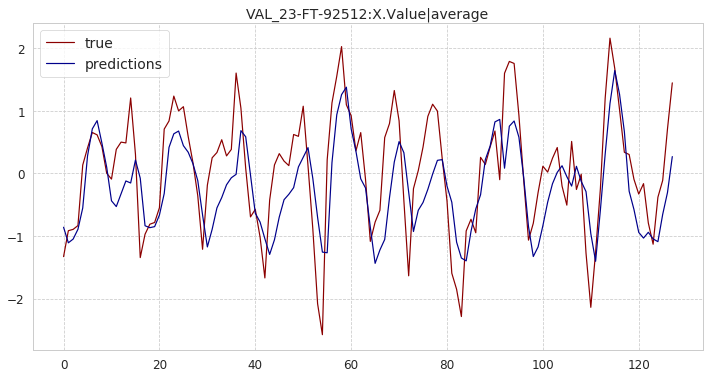

In [73]:
print("MAE = {0}".format(evaluate_model(model, x_valid, y_valid)))
plot_prediction(model, x_valid, y_valid, 0, 128)